#### 0) Chargement des librairies et jeu de données

In [1]:
import numpy as np
import copy as cp
from utils import prox_l1, prox_oblique
import scipy.io

In [2]:
import torch
from torch.utils.data import DataLoader,Dataset,Subset
import matplotlib.pyplot as plt
import matplotlib
import pylab
from utils import My_dataset,train_val_dataset,split_A,plot_train_test_loss,apply_LPALM_realistic
from train import train_non_blind,train_blind
from ISTA import ISTA
from PALM import PALM
from LISTA import LISTA
import argparse
import numpy as np
import torch.nn as nn
import pickle

In [3]:
#Chargement du jeu de données d'entrainement
with open('train_set.pickle', 'rb') as f:
      train_set = pickle.load(f)
with open('val_set.pickle', 'rb') as f:
      val_set = pickle.load(f)
torch.manual_seed(42)
train_loader = DataLoader(train_set, batch_size=1, shuffle=False, num_workers=0) #4)
val_loader = DataLoader(val_set,batch_size=1, shuffle=False, num_workers=0) #4)

In [4]:
#Accès aux élments d'un jeu de données (Indexation)

feature1 = next(iter(train_loader))
print(f"Le jeu de données est composé de {len(feature1)} éléments: X, A et S")

print(f" la taille d'un sample de X: {feature1[0].size()}")
print(f" la taille d'un sample de A: {feature1[1].size()}")
print(f" la taille d'un sample de S: {feature1[2].size()}")

Le jeu de données est composé de 3 éléments: X, A et S
 la taille d'un sample de X: torch.Size([1, 198, 10000])
 la taille d'un sample de A: torch.Size([1, 198, 4])
 la taille d'un sample de S: torch.Size([1, 4, 10000])


In [5]:
#Chargement des données de ground truth

X_jasper = scipy.io.loadmat('Y.mat')
X_jasper = list(X_jasper.items())
X_jasper = np.array(X_jasper,dtype=object)
X_jasper = X_jasper[7,1]
X_jasper = torch.tensor(X_jasper.astype(float))
#X_jasper = torch.reshape(X_jasper,(1,198,10000))
# np.shape(X_jasper)

A_jasper = scipy.io.loadmat('M.mat')
A_jasper = list(A_jasper.items())
A_jasper = np.array(A_jasper,dtype=object)
A_jasper = A_jasper[4,1]
#A_jasper = torch.tensor(A_jasper.astype(float))
#A_jasper = torch.reshape(A_jasper,(1,198,4))
#np.shape(A_jasper)

#A_jasper = np.reshape(A_jasper.detach().numpy(),(198,4))
#A_jasper

S_jasper = scipy.io.loadmat('A.mat')
S_jasper = list(S_jasper.items())
S_jasper = np.array(S_jasper,dtype=object)
S_jasper = S_jasper[3,1]
#S_jasper = torch.tensor(S_jasper.astype(float))
#S_jasper = torch.reshape(S_jasper,(1,4,10000))
#np.shape(S_jasper)

#S_jasper = np.resize(S_jasper.detach().numpy(),(4,10000))
#S_jasper

In [6]:
#Normalisation des colonnes de A (dans la sphère L2)
A_jasper_norm = np.copy(A_jasper)

for i in range(A_jasper.shape[1]):
    A_jasper_norm[:,i] /= np.linalg.norm(A_jasper_norm[:,i])

In [7]:
#Normalisation des colonnes de X (dans la sphère L2)
X_jasper_norm = np.copy(X_jasper).astype(np.float32)

for j in range(np.shape(X_jasper_norm)[1]):
    X_jasper_norm[:,j] /= np.linalg.norm(X_jasper_norm[:,j])

In [8]:
#Calcul des distances du jeu de grount truth par rapport aux jeux d'entrainements

#a) Jeu de référence:(Ground truth)
A0 = np.copy(A_jasper_norm)

#b) Calcul des distances par rapport aux spectres du training set
l = []

for i,(X,A,S) in enumerate(train_set):
    crit = np.sum(np.multiply(A0[:,0],A[:,0])) / (np.linalg.norm(A0[:,0]) * np.linalg.norm(A[:,0])) + np.sum(np.multiply(A0[:,1],A[:,1])) / (np.linalg.norm(A0[:,1]) * np.linalg.norm(A[:,1])) + np.sum(np.multiply(A0[:,2],A[:,2])) / (np.linalg.norm(A0[:,2]) * np.linalg.norm(A[:,2])) + np.sum(np.multiply(A0[:,3],A[:,3])) / (np.linalg.norm(A0[:,3]) * np.linalg.norm(A[:,3]))
    l.append(crit)

In [9]:
print(f"Min distance : {min(l)}, it correspond to the index :{np.where(l == min(l))[0]}")
#Comme c'est un ratio (distance angulaire), le jeu le plus éloigné sera le jeu dont le ratio est le plus petit.

Min distance : 3.9817271401086423, it correspond to the index :[31]


In [10]:
print(f"Max distance : {max(l)}, it correspond to the index :{np.where(l == max(l))[0]}")
#Comme c'est un ratio (distance angulaire), le jeu le plus éloigné sera le jeu dont le ratio est le plus petit.

Max distance : 3.996515297752932, it correspond to the index :[61]


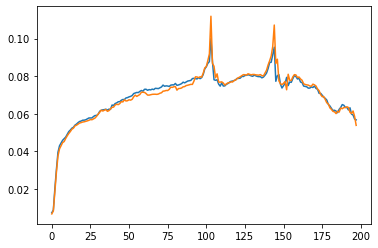

In [14]:
#c) Affichage des deux jeux de A 
#Point de départ du PALM
#plt.figure(figsize=(15,10))
plt.plot(A0[:,3]) #Base de comparaison
plt.plot(train_set[31][1][:,3]) #Jeu le plus éloigné selon l'écrat angulaire

### Evaluation du PALM

In [15]:
#Fonction ReLU pour le PALM
def prox_relu(S_est,thrd): #numpy
  S_est[(S_est <= thrd)] = 0
  indNZ = np.where(S_est > thrd)[0]
  S_est[indNZ] = S_est[indNZ] - thrd*np.sign(S_est[indNZ])
  return S_est

In [16]:
#Spectral mean error
def Spectral_ME(A_est, A_star):
    score = 0
    for i in range(4):
        score = score + np.linalg.norm(A_star[:,i] - A_est[:,i], ord=2)
    return score/(198*4)

In [17]:
#Normalized spectral mean error
def Normalized_SME(A_est, A_star):
    score = 0
    for i in range(4):
        score = np.linalg.norm(A_star[:,i] - A_est[:,i], ord=2)
    return score/np.linalg.norm(A_star[:,i], ord=2)

In [18]:
#Abundance mean error
def Abundance_ME(S_est, S_star):
    score = 0
    for i in range(4):
        score = score + np.linalg.norm(S_star[i,:] - S_est[i,:], ord=1)
    return score/(4*10000)

In [19]:
#Normalized spectral mean error
def Normalized_AME(S_est, S_star):
    score = 0
    for i in range(4):
        score = np.linalg.norm(S_star[i,:] - S_est[i,:], ord=1)
    return score/np.linalg.norm(S_star[i,:] , ord=1)

In [31]:
#e) Evaluation du PALM pour différentes valeurs de lambda (Choix en fonction de la métrique)
#En initialisant par l'ensemble des samples d'entrainement


S_sample_list = [] #To memorize the lowest S of each sample (w.r.t lambda)
A_sample_list = [] #To memorize the lowest A of each sample (w.r.t lambda)
lambda_sample_list = [] #To memorize the best lambda for each sample
Loss_sample_list = [] #To memorize the loss of each sample

for k in range(np.shape(train_set)[0]):

    Ainit = train_set[k][1]

    X = np.reshape(np.asarray(X_jasper_norm),(198, 10000))
    n=4
    #lamb=1
    nbIt = 100#0e0
    eps = 0.01

    S_int = [] #To memorize the result of each lambda (after all iterations)
    A_int = []

    Loss = [] #To memorize the loss of each lambda
    
    #A_est = Ainit.copy() #init_A_est
    #S_est = np.dot(np.linalg.pinv(A_est),X) #init_S_est
    
    lamb_list = [0.1, 0.2, 0.3] #, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1]
    
    for lamb in lamb_list: #[:11]: #1]:
    
        A_est = Ainit.copy() #init_A_est
        S_est = np.dot(np.linalg.pinv(A_est),X) #init_S_est
    
        for i in range(nbIt):
            # S update
            gamma = 1./((np.linalg.norm(A_est,ord=2)**2)*(1.+eps))
            S_est = S_est + gamma*np.dot(A_est.T,(X - A_est@S_est))
        
            S_est = prox_l1(S_est,lamb*gamma)
            #S_est = np.maximum(S_est,lamb*gamma*np.ones(np.shape(S_est)))
            #for j in range(np.shape(S)[0]):
            #    S_est[:,j] /=np.linalg.norm(S_est,ord=1, axis=1)[j]
    
            # A update 
            eta = 1./((np.linalg.norm(S_est,ord=2)**2) *(1+eps))
            A_est = A_est + eta*(X - A_est@S_est)@S_est.T

            A_est = A_est*(A_est>0)
            A_est = prox_oblique(A_est)
    
        S_int.append(S_est)
        A_int.append(A_est)
        Loss.append(Normalized_SME(A_est,A_jasper_norm) + Normalized_AME(S_est, S_jasper)) 
        
    S_sample_list.append(S_int[Loss.index(min(Loss))])
    A_sample_list.append(A_int[Loss.index(min(Loss))])
    Loss_sample_list.append(min(Loss))
    lambda_sample_list.append(lamb_list[Loss.index(min(Loss))])

In [35]:
S_sample_list

[array([[0.37255946, 0.38086989, 0.56492423, ..., 0.75970095, 0.7986355 ,
         0.79949149],
        [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
         0.        ],
        [0.4372512 , 0.42923627, 0.24395733, ..., 0.04098821, 0.        ,
         0.        ],
        [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
         0.        ]]),
 array([[0.33811458, 0.34690623, 0.53130342, ..., 0.72539834, 0.78453496,
         0.79947761],
        [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
         0.        ],
        [0.47131163, 0.4628251 , 0.27789495, ..., 0.07643619, 0.01299084,
         0.        ],
        [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
         0.        ]]),
 array([[0.37311563, 0.38195409, 0.56921706, ..., 0.76240227, 0.79866697,
         0.79947366],
        [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
         0.        ],
        [0.43647822, 0.42790637, 0.2

#### Definition of the PALM algorithm

def PALM(X,n=4,lamb=0,nbIt = 50e0,Ainit=A_init): #Ainit is the A initializing PALM
    S_int = [] #To memorize the result at each iteration
    A_int = []
    
    eps=0.01    
    A_est = Ainit.copy() #init_A_est
    S_est = np.dot(np.linalg.pinv(A_est),X) #init_S_est
    
    A_est_prev = A_est.copy()
    S_est_prev = S_est.copy()
    
    it = 0
    while((np.linalg.norm(S_est-S_est_prev) > 1e-7 or np.linalg.norm(A_est-A_est_prev) > 1e-7 or it < 2) and it < nbIt):

        if np.mod(it,100) == 2:
            print(it)
            print('Cs : %s, Ca : %s'%(np.linalg.norm(S_est-S_est_prev),np.linalg.norm(A_est-A_est_prev)))
        
        if it > 0:
            S_est_prev = cp.copy(S_est)
            A_est_prev = cp.copy(A_est)
            
            
        # S update
        gamma = 1./((np.linalg.norm(A_est,ord=2)**2)*(1.+eps))
        S_est = S_est + gamma*A_est.T@(X - A_est@S_est)
        

        S_est = prox_l1(S_est,lamb*gamma)
        
        # A update 
        eta = 1./((np.linalg.norm(S_est,ord=2)**2) *(1+eps))
        A_est = A_est + eta*(X - A_est@S_est)@S_est.T
        
        A_est = A_est*(A_est>0)
        A_est = prox_oblique(A_est)

        it += 1
        S_int.append(S_est)
        A_int.append(A_est)
    return A_est,S_est,it,S_int,A_int

#### PALM modifié, (avec les mêmes contraintes que le LPALM)

In [272]:
#f) Evaluation du PALM pour différentes valeurs de lambda (Choix en fonction de la métrique)
Ainit = train_set[31][1]

X = np.reshape(np.asarray(X_jasper_norm),(198, 10000))
n=4
#lamb=1
nbIt = 200#0e0

S_int = [] #To memorize the result at each iteration
A_int = []

lamb_list = [0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1]

Loss = []
    
eps = 0.01    

for lamb in lamb_list: #[:11]: #1]:
    
    A_est = Ainit.copy() #init_A_est
    S_est = np.dot(np.linalg.pinv(A_est),X) #init_S_est
    
    
    for i in range(nbIt):
        # S update
        gamma = 1./((np.linalg.norm(A_est,ord=2)**2)*(1.+eps))
        S_est = S_est + gamma*np.dot(A_est.T,(X - A_est@S_est))
        
        S_est = prox_relu(S_est,lamb*gamma) #ReLU
        for j in range(np.shape(S_jasper)[1]): #Simplexe
            S_est[:,j] /= np.sum(S_est[:,j])
    
        # A update 
        eta = 1./((np.linalg.norm(S_est,ord=2)**2) *(1+eps))
        A_est = A_est + eta*(X - A_est@S_est)@S_est.T

        A_est = A_est*(A_est>0)
        A_est = prox_oblique(A_est)
    
    S_int.append(S_est)
    A_int.append(A_est)
    Loss.append(Spectral_ME(A_est,A_jasper_norm) + Abundance_ME(S_est, S_jasper))

[0.1562259330702132,
 0.09510335041338612,
 0.10255988533569106,
 0.10499201117260207,
 0.10612148677396394,
 0.10747325061687739,
 0.109498759464279,
 0.11102834037753996,
 0.11225436594639737,
 0.11378545670589661,
 0.11500500433349985]

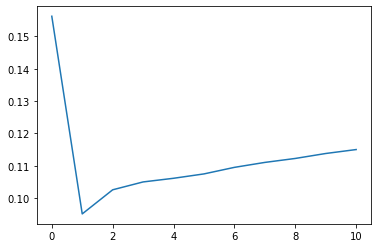

In [273]:
plt.plot(Loss)
Loss

In [28]:
#f) Evaluation du PALM pour différentes valeurs de lambda (Choix en fonction de la métrique)
Ainit = train_set[31][1]

X = np.reshape(np.asarray(X_jasper_norm),(198, 10000))
n=4
#lamb=1
nbIt = 300#0e0

S_int2 = [] #To memorize the result at each iteration
A_int2 = []

lamb_list = [0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09, 0.1]

Loss2 = []
    
eps = 0.01    

for lamb in lamb_list: #[:11]: #1]:
    
    A_est = Ainit.copy() #init_A_est
    S_est = np.dot(np.linalg.pinv(A_est),X) #init_S_est
    
    
    for i in range(nbIt):
        # S update
        gamma = 1./((np.linalg.norm(A_est,ord=2)**2)*(1.+eps))
        S_est = S_est + gamma*np.dot(A_est.T,(X - A_est@S_est))
        
        S_est = prox_relu(S_est,lamb*gamma) #ReLU
        for j in range(np.shape(S_jasper)[1]): #Simplexe
            S_est[:,j] /= np.sum(S_est[:,j])
    
        # A update 
        eta = 1./((np.linalg.norm(S_est,ord=2)**2) *(1+eps))
        A_est = A_est + eta*(X - A_est@S_est)@S_est.T

        A_est = A_est*(A_est>0)
        A_est = prox_oblique(A_est)
    
    S_int2.append(S_est)
    A_int2.append(A_est)
    Loss2.append(Spectral_ME(A_est,A_jasper_norm) + Abundance_ME(S_est, S_jasper))

[0.14438917871154608,
 0.10506252334584709,
 0.05988831422031654,
 0.07707312321666507,
 0.08922182438916285,
 0.09122960992205609,
 0.09186906960189274,
 0.09242069446263758,
 0.09307495886297862,
 0.09394645536852587]

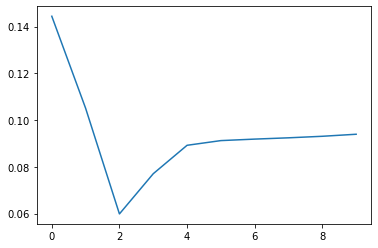

In [29]:
plt.plot(Loss2)
Loss2

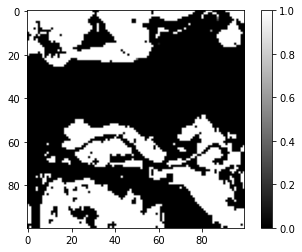

In [285]:
i=0
plt.imshow(S_int[3].reshape([4,100,100])[i], cmap='gray')
plt.colorbar() # /!\ Si le nombre d'itérations est trop élevé ça va aller dans le sens du A en négligeant le S /!\ 

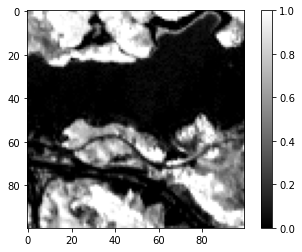

In [286]:
plt.imshow(S_jasper.reshape([4,100,100])[i], cmap='gray')
plt.colorbar()

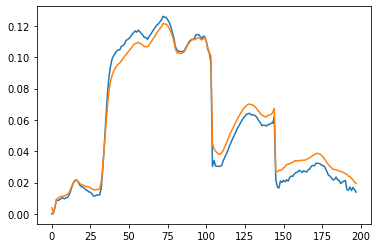

In [294]:
k=0
#plt.figure(figsize=(15,10))
#plt.plot(dataset1[188][1][:,k],"+")
plt.plot(A0[:,k]) #,".") #Base de comparaison
plt.plot(A_int[3][:,k])

In [385]:
#f) Evaluation du PALM pour différentes valeurs de lambda (Choix en fonction de la métrique)
Ainit = dataset1[151][1]

X = np.reshape(np.asarray(X_jasper_norm),(198, 10000))
n=4
lamb=0.04
nbIt = 100
eps = 0.01    

A_est = Ainit.copy() #init_A_est
S_est = np.dot(np.linalg.pinv(A_est),X) #init_S_est
    

Loss_A = []
Loss_S = []
Joint_Loss = []

    
for i in range(nbIt):
    # S update
    gamma = 1./((np.linalg.norm(A_est,ord=2)**2)*(1.+eps))
    S_est = S_est + gamma*np.dot(A_est.T,(X - A_est@S_est))
        
    S_est = prox_relu(S_est,lamb*gamma) #ReLU
    for j in range(np.shape(S_jasper)[1]): #Simplexe
            S_est[:,j] /= np.sum(S_est[:,j])
    
    # A update 
    eta = 1./((np.linalg.norm(S_est,ord=2)**2) *(1+eps))
    A_est = A_est + eta*(X - A_est@S_est)@S_est.T

    A_est = A_est*(A_est>0)
    A_est = prox_oblique(A_est)
    
    if (i+1)%25 == 0: #Trouver le nombre d'itérations optimal
        Loss_A.append(Spectral_ME(A_est,A_jasper_norm))
        Loss_S.append(Abundance_ME(S_est, S_jasper))
        Joint_Loss.append(Spectral_ME(A_est,A_jasper_norm) + Abundance_ME(S_est, S_jasper))

In [386]:
Joint_Loss

[0.06488866706823936,
 0.047399067110654954,
 0.03749582652420098,
 0.03838057868483739]

In [387]:
Loss_A

[0.0005623098736987021,
 0.0003951700117703479,
 0.0002615631672550129,
 0.00019696414744569676]

In [388]:
Loss_S

[0.06432635719454065,
 0.047003897098884605,
 0.03723426335694596,
 0.03818361453739169]

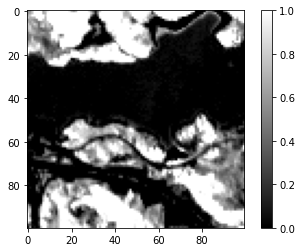

In [399]:
i=0
plt.imshow(S_est.reshape([4,100,100])[i], cmap='gray')
plt.colorbar()

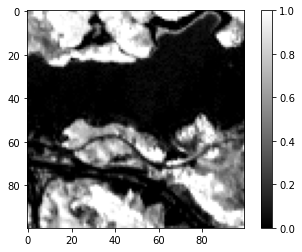

In [400]:
plt.imshow(S_jasper.reshape([4,100,100])[i], cmap='gray')
plt.colorbar()

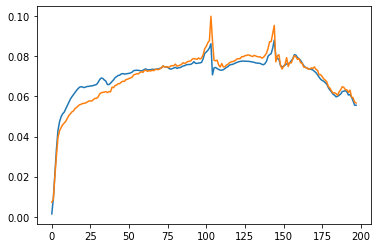

In [401]:
k=3
#plt.figure(figsize=(15,10))
plt.plot(A_est[:,k])
plt.plot(A0[:,k]) #,".") #Base de comparaison

In [18]:
S_jasper

array([[0.5599831 , 0.5599831 , 0.70533056, ..., 0.88019298, 0.93468789,
        0.99461036],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.4400169 , 0.4400169 , 0.29466944, ..., 0.11980702, 0.06531211,
        0.00538964],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ]])

### Evaluation du PALM sur des patchs d'images

In [19]:
#Redimensionnement de S en image 198*100*100 (GT)
#Découpage en 4 sous-parties de 50*50
S_jasper_reshaped = torch.reshape(torch.tensor(S_jasper), [1,4,100,100])
S_part_jasper1 = S_jasper_reshaped[:,:,:50,:50]
S_part_jasper2 = S_jasper_reshaped[:,:,:50,50:100]
S_part_jasper3 = S_jasper_reshaped[:,:,50:100,:50]
S_part_jasper4 = S_jasper_reshaped[:,:,50:100,50:100]

In [55]:
#Redimensionnement de l'image hyperspectrale en 198*100*100
#Découpage de l'image X en 4 sous-paties 50*50

X_jasper_reshaped = torch.reshape(torch.tensor(X_jasper),[1,198,100,100])

X_jr_1 = X_jasper_reshaped[:,:,:50,:50]
X_1 = torch.reshape(X_jr_1,[1,198,50*50])

X_jr_2 = X_jasper_reshaped[:,:,:50,50:100]
X_2 = torch.reshape(X_jr_2,[1,198,50*50])

X_jr_3 = X_jasper_reshaped[:,:,50:100,:50]
X_3 = torch.reshape(X_jr_3,[1,198,50*50])

X_jr_4 = X_jasper_reshaped[:,:,50:100,50:100]
X_4 = torch.reshape(X_jr_4,[1,198,50*50])


#Test avec X_jasper dont les colonnes sont normalisées selon une norme L2
X_jr_1_norm = X_1.clone()
X_jr_2_norm = X_2.clone()
X_jr_3_norm = X_3.clone()
X_jr_4_norm = X_4.clone()

/tmp/ipykernel_29579/1088290249.py:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_jasper_reshaped = torch.reshape(torch.tensor(X_jasper),[1,198,100,100])


In [84]:
#Application du PALM sur la sous-partie 1:
Ainit = dataset1[151][1]

n=4
lamb = 0.07
eps = 0.01 
nbIt = 300#0e0

v = [] #To memorize the result at each iteration
All_A_estimated = []
All_S_estimated = []


Loss = []

S_jasper_parts = [S_part_jasper1, S_part_jasper2, S_part_jasper3, S_part_jasper4]

list_X_parts = [X_jr_1_norm, X_jr_2_norm, X_jr_3_norm, X_jr_4_norm]

for part in list_X_parts:
    
    #p = 0
    
    X = np.reshape(np.asarray(part),(198, 2500))
   
    A_est = Ainit.copy() #init_A_est
    S_est = np.dot(np.linalg.pinv(A_est),X) #init_S_est

    for i in range(nbIt):
        # S update
        gamma = 1./((np.linalg.norm(A_est,ord=2)**2)*(1.+eps))
        S_est = S_est + gamma*np.dot(A_est.T,(X - A_est@S_est))
        
        S_est = prox_l1(S_est,lamb*gamma)
    
        # A update 
        eta = 1./((np.linalg.norm(S_est,ord=2)**2) *(1+eps))
        A_est = A_est + eta*(X - A_est@S_est)@S_est.T

        A_est = A_est*(A_est>0)
        A_est = prox_oblique(A_est)
    
    #Loss.append(Spectral_ME(A_est,A_jasper_norm) + Abundance_ME(S_est, S_jasper_parts[i]))
    #p+=1
    
    All_S_estimated.append(S_est)
    All_A_estimated.append(A_est)

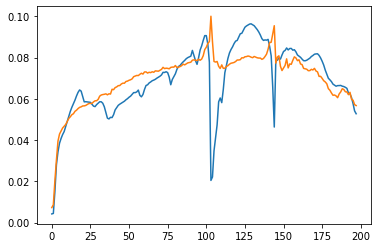

In [131]:
k=
#plt.figure(figsize=(15,10))
plt.plot(All_A_estimated[0][:,k])
plt.plot(A0[:,k]) #,".") #Base de comparaison

In [132]:
sum(All_A_estimated[3][:,k]**2)

0.9999999999999993

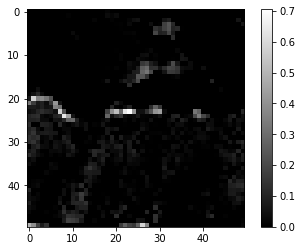

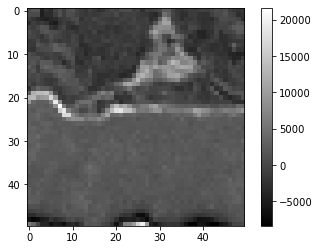

In [107]:
i=3

plt.imshow(S_part_jasper1.reshape([4,50,50])[i], cmap='gray')
plt.colorbar()
plt.show()

plt.imshow(All_S_estimated[0].reshape([4,50,50])[i], cmap='gray')
plt.colorbar()
plt.show()

In [104]:
All_S_estimated[0]

array([[16735.19679704, 17991.19668575, 19923.15949331, ...,
          386.20556678,   387.8595093 ,   200.01490612],
       [  548.27093386,   243.21148154,   370.03650003, ...,
         3239.52664924,  3257.6181538 ,  3134.55646576],
       [14020.41128172, 13841.19439338,  8919.9209962 , ...,
          589.72598779,   213.43771504,  -234.18086621],
       [  475.52508814,  1684.73909295,  1578.70025245, ...,
         -492.95714711,  -382.07580325,   453.81819884]])